# Edibility of Mushrooms
## Introduction
Mushrooms are important in our diet, since they are an essential source of nutrition including niacin, riboflavin, selenium, potassium, and vitamin D which are precluding of hypertension, Alzheimer, Parkinson, and high risk of stroke (Jahan Pinky et al., 2019). However, not all species of mushroom are edible. According to Chowdhury and Ojha (2017), humans have identified 45,000 species of mushrooms worldwide, but the number of edible species is only 2000. Plus, identifying the edibility of a mushroom is a task too difficult to be done manually (Jahan Pinky et al., 2019). Automation through machine learning seems to be a feasible solution. Therefore, in our project, we attempt to apply the classification algorithm to predict the edibility of mushroom using data of its physical characteristics and briefly evaluate the performance of our model. 

### The Dataset
"Secondary mushroom data" from UCI Machine Learning Repository (https://mushroom.mathematik.uni-marburg.de/files/) is used to answer the question. This dataset includes 61069 hypothetical mushrooms with caps based on 173 species (353 mushrooms per species). Each mushroom is identified as one of two classes: edible(e) and poisonous(p), and each observation of a mushroom contains 20 variables. Of the 20 variables, 3 are continuous, and 17 are nominal (3 binary, and 14 categorical). 18 of them are physical characteristics of the mushroom, and 2 are of the mushrooms' growing habitat and season.

## Methods & Results
describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.

- √ loads data from the original source on the web 
- √ wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
- √ performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- ? creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis (ADD EXPLANATION)
- √ performs the data analysis
- creates a visualization of the analysis 

- !! note: all tables and figure should have a figure/table number and a legend

### Loads data from the original source on the web

In [1]:
library(tidyverse)
library(tidymodels)
library(cowplot)
set.seed(777)
link <- "https://mushroom.mathematik.uni-marburg.de/files/SecondaryData/secondary_data_shuffled.csv"
mushrooms <- read_delim(link, delim=";") # download our dataset
head(mushrooms) # show the first 6 examples

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,⋯,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
<chr>,<dbl>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>
e,1.72,x,s,y,FALSE,d,NA,w,7.01,⋯,NA,t,y,NA,NA,FALSE,f,NA,h,u
e,9.59,f,e,b,FALSE,NA,c,b,4.73,⋯,NA,NA,w,NA,NA,TRUE,f,NA,d,a
p,0.86,x,g,p,FALSE,a,NA,p,4.25,⋯,NA,s,k,NA,NA,FALSE,f,NA,d,s
p,4.32,x,NA,e,FALSE,x,NA,w,4.91,⋯,NA,NA,w,NA,NA,FALSE,f,NA,d,u
e,2.80,x,s,w,FALSE,d,d,w,3.13,⋯,NA,NA,w,NA,NA,FALSE,f,NA,m,a
p,1.18,s,s,y,FALSE,f,f,f,3.39,⋯,NA,NA,y,NA,NA,FALSE,f,NA,d,u


Table 1. The first 6 rows of the "Secondary Mushroom Data" dataset

### Wrangles and cleans the data

In [2]:
new_colnames <- map(colnames(mushrooms), function (col_name) gsub("-", "_", col_name)) # replace '-' with '_'
new_colnames[2] <- 'diameter' # compact the names of diameter, height, and width
new_colnames[10] <- 'height'
new_colnames[11] <- 'width'
colnames(mushrooms) <- new_colnames
mushroom_split <- mushrooms |>
    mutate(across(-c(diameter, height, width), factor)) |>
    initial_split(prop=0.75, strata=class)
mushroom_training_raw <- training(mushroom_split)
mushroom_training <- mushroom_training_raw |>
    select(class, diameter, height, width)
head(mushroom_training)

class,diameter,height,width
<fct>,<dbl>,<dbl>,<dbl>
e,9.59,4.73,20.49
e,5.76,8.11,17.69
e,11.53,8.99,18.61
e,1.48,5.39,2.56
e,12.59,12.33,15.40
e,1.40,5.97,1.80


Table 2. The first 6 rows of a cleaned and wrangled "Secondary Mushroom Data" with only diamter, height, and width as variables.

### A summary of the data set

In [3]:
#This table reports the number of observations in each class
summarize_mushroom <- mushroom_training |>
    group_by(class) |>
    summarize(n = n())
summarize_mushroom

class,n
<fct>,<int>
e,20385
p,25416


Table 3.1. The number of observations in each class (edible(e)/poisonous(p))

In [4]:
#This table gives the means of the predictor variables in our analysis
means_mushroom <- mushroom_training |>
    select(-class) |>
    map_df(mean)
    means_mushroom

diameter,height,width
<dbl>,<dbl>,<dbl>
6.729185,6.574405,12.11532


Table 3.2. The means of the predictor variables in our analysis

In [10]:
#This calculates the number of rows that have missing data
missing_data <- mushroom_training |>
    filter(is.na(class) || is.na(diameter) || is.na(height) || is.na(width)) |>
    nrow()
missing_data

[1] 0

Therefore, 0 rows in the dataset have missing data.

### Visualization of predictive (continuous) variables 

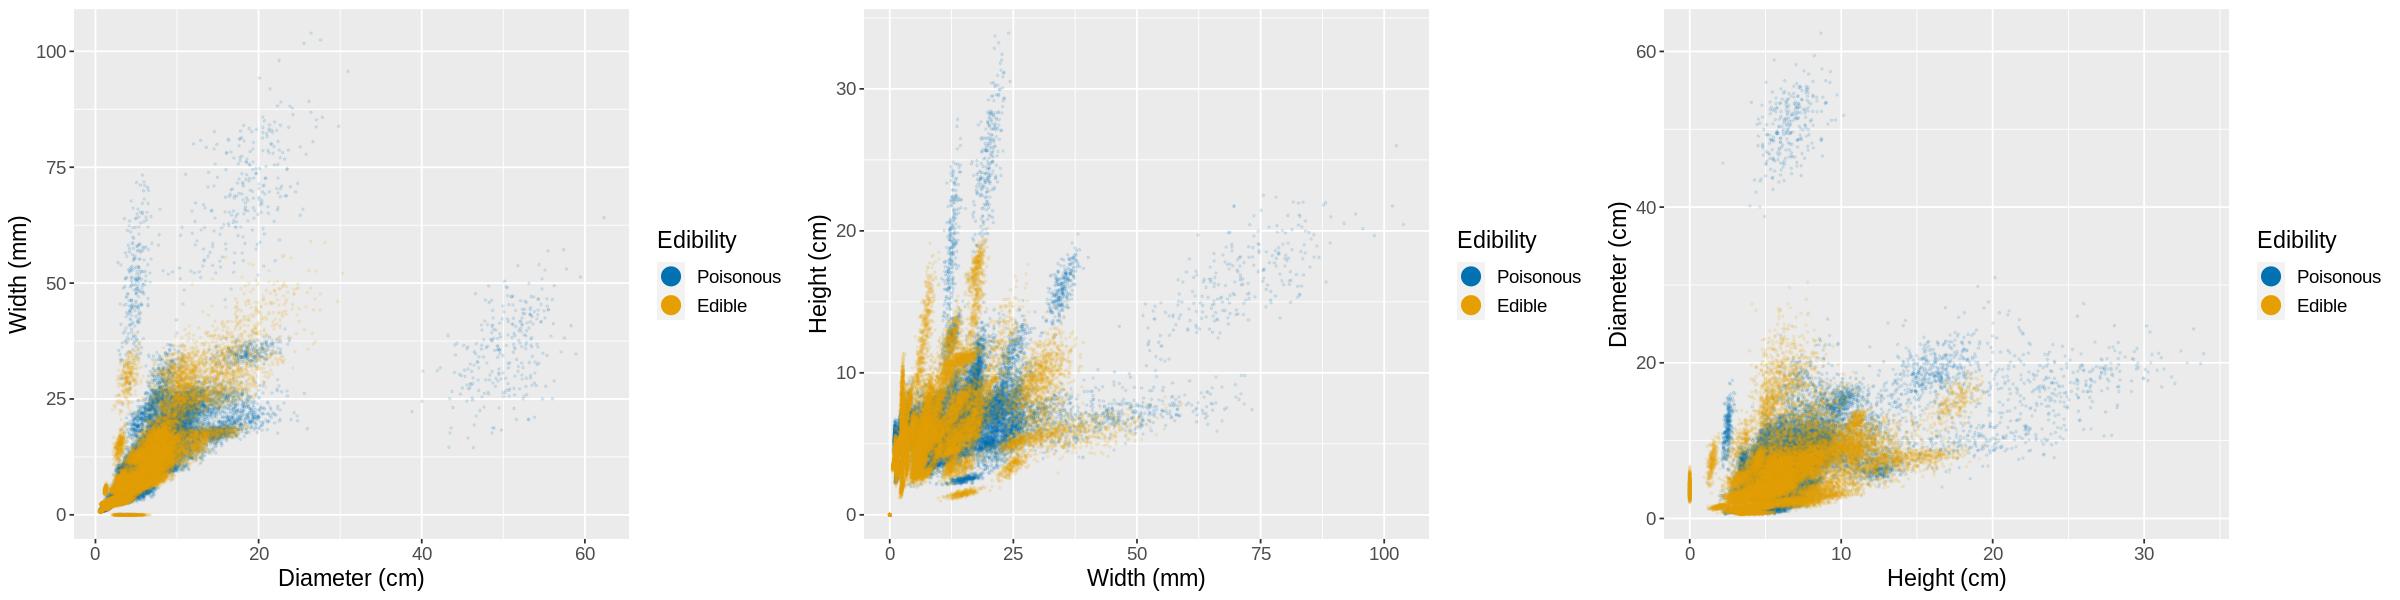

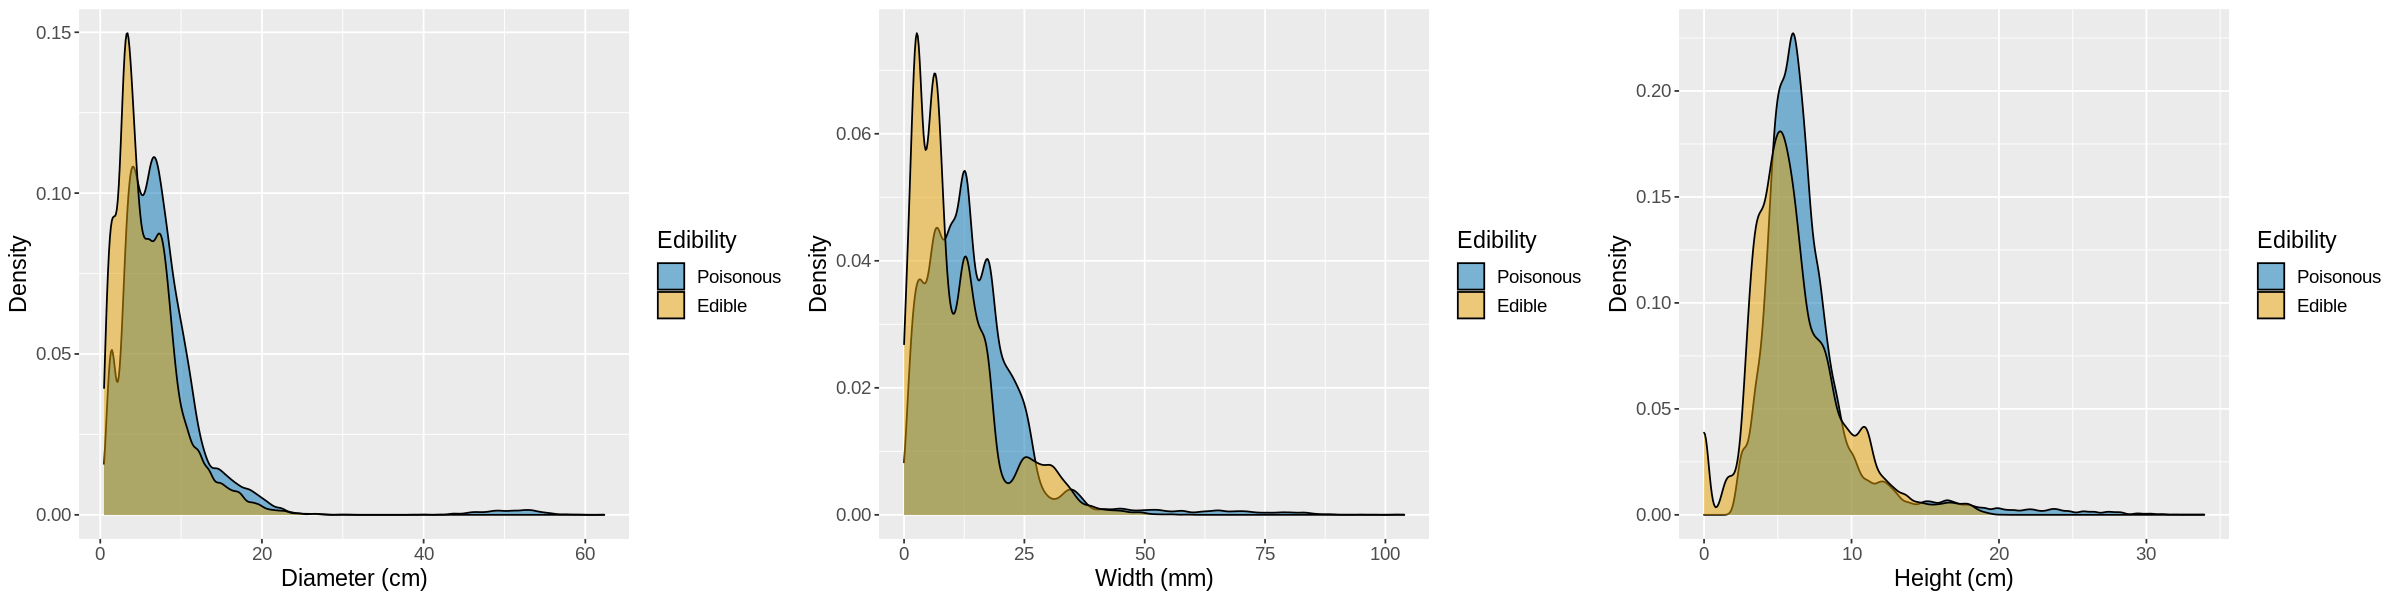

In [11]:
# Width vs. Diameter
mushroom_plot1 <- mushroom_training |>
    ggplot(aes(x=diameter, y=width, color=class)) +
    geom_point(alpha=0.1, size=.4) +
    labs(x="Diameter (cm)", y="Width (mm)", color="Edibility") +
    scale_color_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    theme(text=element_text(size=14)) + 
    guides(color = guide_legend(override.aes = list(alpha=1, size = 5)))

# Height vs. Width
mushroom_plot2 <- mushroom_training |>
    ggplot(aes(x=width, y=height, color=class)) +
    geom_point(alpha=0.1, size=.4) +
    labs(x="Width (mm)", y="Height (cm)", color="Edibility") +
    scale_color_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    theme(text=element_text(size=14)) + 
    guides(color = guide_legend(override.aes = list(alpha=1, size = 5)))

# Diameter vs. Height
mushroom_plot3 <- mushroom_training |>
    ggplot(aes(x=height, y=diameter, color=class)) +
    geom_point(alpha=0.1, size=.4) +
    labs(x="Height (cm)", y="Diameter (cm)", color="Edibility") +
    scale_color_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    theme(text=element_text(size=14)) + 
    guides(color = guide_legend(override.aes = list(alpha=1, size = 5)))

# Marginal density plot of diamter (top panel)
diameterDensity <- ggplot(mushroom_training, aes(diameter, fill=class)) + 
    geom_density(alpha=.5) + 
    labs(x = "Diameter (cm)", y = "Density", fill = "Edibility") +
    scale_fill_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    #theme(legend.position = "none") +
    theme(text=element_text(size=14))
#diameterDensity

# Marginal density plot of width (right panel)
widthDensity <- ggplot(mushroom_training, aes(width, fill=class)) + 
    geom_density(alpha=.5) + 
    labs(x = "Width (mm)", y = "Density", fill = "Edibility") +
    scale_fill_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    #theme(legend.position = "none") +
    theme(text=element_text(size=14))
#widthDensity

# Marginal density plot of height
heightDensity <- ggplot(mushroom_training, aes(height, fill=class)) + 
    geom_density(alpha=.5) + 
    labs(x = "Height (cm)", y = "Density", fill = "Edibility") +
    scale_fill_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    #theme(legend.position = "none") +
    theme(text=element_text(size=14))
#heightDensity

options(repr.plot.width = 20, repr.plot.height = 5)
plot_grid(mushroom_plot1, mushroom_plot2, mushroom_plot3, ncol = 3)
plot_grid(diameterDensity, widthDensity, heightDensity, ncol = 3)

### Data Analysis

#### Finding the Optimal `k` value and Building the Final Model
- First, we will build new components that need to be updated for our final model.
    - mainly, we need a new set of `k` values to test and a new workflow.
- We will then tune our model with various `k` values, and pick the best one through a visualization.

In [8]:
k <- 10
mushroom_recipe <- recipe(class ~ diameter + height + width, data=mushroom_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
mushroom_spec <- nearest_neighbor(weight_func="rectangular", neighbors=k) |>
    set_engine("kknn") |>
    set_mode("classification")
mushroom_fit <- workflow() |>
    add_recipe(mushroom_recipe) |>
    add_model(mushroom_spec) |>
    fit(data = mushroom_training)
mushroom_predicted <- mushroom_fit |>
    predict(mushroom_training) |>
    bind_cols(mushroom_training)
training_metrics <- mushroom_predicted |>
    metrics(truth=class, estimate=.pred_class)
training_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8375800
kap,binary,0.6710696


# Discussion
summarize what you found
- discuss whether this is what you expected to find?
- √ discuss what impact could such findings have?
- √ discuss what future questions could this lead to?

#### - Finding:

#### - Impact:

There is currently no common methodologies other than relying on a mushroom expert to distinguish between poisonous and edible mushrooms (citation: https://www.betterhealth.vic.gov.au/health/healthyliving/fungi-poisoning). Our model could provide the public a tool for identifying the edibility of varieties and assist experts in making judgments. 

#### - Future Questions and possible improvements:

Our model could be difficult both to collect data for and to use because of the large number of features. Future data scientists might adjust our model to take images as input to make these easier. Additionally, an improved model might use regression to predict a numerical value for a mushroom's toxicity to better represent its non-binary effects.

# References
- Jahan Pinky, N., Mohidul Islam, S. M., &amp; Sharmin Alice, R. (2019). Edibility detection of mushroom using ensemble methods. International Journal of Image, Graphics and Signal Processing, 11(4), 55–62. https://doi.org/10.5815/ijigsp.2019.04.05 
- D. R. Chowdhury, S. Ojha. (2017). An Empirical Study on Mushroom Disease Diagnosis: A Data Mining Approach. International Research Journal of Engineering and Technology, 4(1), 529-534.

Data set:
- UCI Machine Learning Repository. (1987). Mushroom data set. 
https://archive.ics.uci.edu/ml/datasets/mushroom 